# ESA Advanced Training Course on Radar Polarimetry - June 14, 2023 
# The InSAR Coherence & Forest Height Inversion

* TanDEM-X acquisition over Mondah forest (Gabon)
* Path: '/projects/data/03-insar/'
* SLCs: master_HH_Mondah_S_2015_11_11_cut.npy, slave_HH_Mondah_S_2015_11_11_cut.npy
* Flat-earth: flat_earth_Mondah_S_2015_11_11_cut.npy
* Full-waveform Lidar (LVIS) RH100: RH100_Mondah_S_2015_11_11_cut.npy

Objective:
- Calculate InSAR coherence with a 20 m resolution, estimate forest height using the provided formula, and validate the result against lidar
- carry out a performance analysis, and recognize performance factors and improvement possibilities

Tips:
- Compensate system decorrelation 0.97
- Invalid points in the RH100 are set to -9999

In [3]:
# import useful libraries, functions, and modules

import sys
sys.path.append('/projects/src/')

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import filters
from ste_io import *
from tqdm import tqdm

%matplotlib widget


In [4]:
def calculate_covariance(im1, im2, looksr, looksa) : 
    
    corr = filters.uniform_filter(np.real(im1*np.conj(im2)), [looksa,looksr]) + 1j* \
                filters.uniform_filter(np.imag(im1*np.conj(im2)), [looksa,looksr])
    
    return corr

**Input parameters**

In [5]:
# path 2 images
path = '/home/data/'

# Input TDX pixel spacing, in meters
spacrg = 1.36411
spacaz = 1.86817

# TDX vertical wavenumber, in rad / meters
kz = 0.06092195

# Output range resolution, in meters
resrg = 20.
resaz = 20.

**Step 1: Open images, and visualize**

/tmp/ipykernel_17184/1883972919.py:3: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  corr = filters.uniform_filter(np.real(im1*np.conj(im2)), [looksa,looksr]) + 1j* \
/tmp/ipykernel_17184/1883972919.py:4: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  filters.uniform_filter(np.imag(im1*np.conj(im2)), [looksa,looksr])


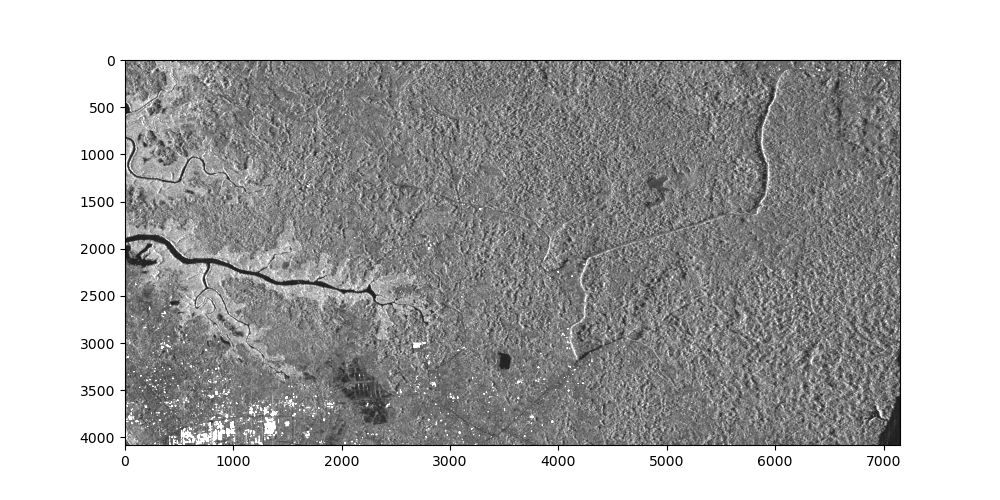

In [6]:
# --- open images
im1 = np.load(path + 'master_HH_Mondah_S_2015_11_11_cut.npy')
im2 = np.load(path + 'slave_HH_Mondah_S_2015_11_11_cut.npy')

# display
amp1 = np.sqrt( np.abs( calculate_covariance(im1, im1, 7, 7) ) )
plt.figure(figsize = (10, 5))
plt.imshow(amp1, vmin = 0, vmax = 2*np.mean(amp1), aspect = 'auto', cmap = 'gray' )



**Step 2 : Compensate flat-earth**

In [7]:
# --- calculate number of looks
looksr = int( resrg / spacrg )
if looksr % 2 == 0 : looksr = looksr +1
looksa = int( resaz / spacaz )
if looksa % 2 == 0 : looksa = looksa +1

# --- open flat-earth phase
fe = np.load(path + 'flat_earth_Mondah_S_2015_11_11_cut.npy')
# --- compensate
im2_fe = im2 * np.exp(1j * fe)


**Step 3 : Calculate coherence**

/tmp/ipykernel_17184/1883972919.py:3: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  corr = filters.uniform_filter(np.real(im1*np.conj(im2)), [looksa,looksr]) + 1j* \
/tmp/ipykernel_17184/1883972919.py:4: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  filters.uniform_filter(np.imag(im1*np.conj(im2)), [looksa,looksr])


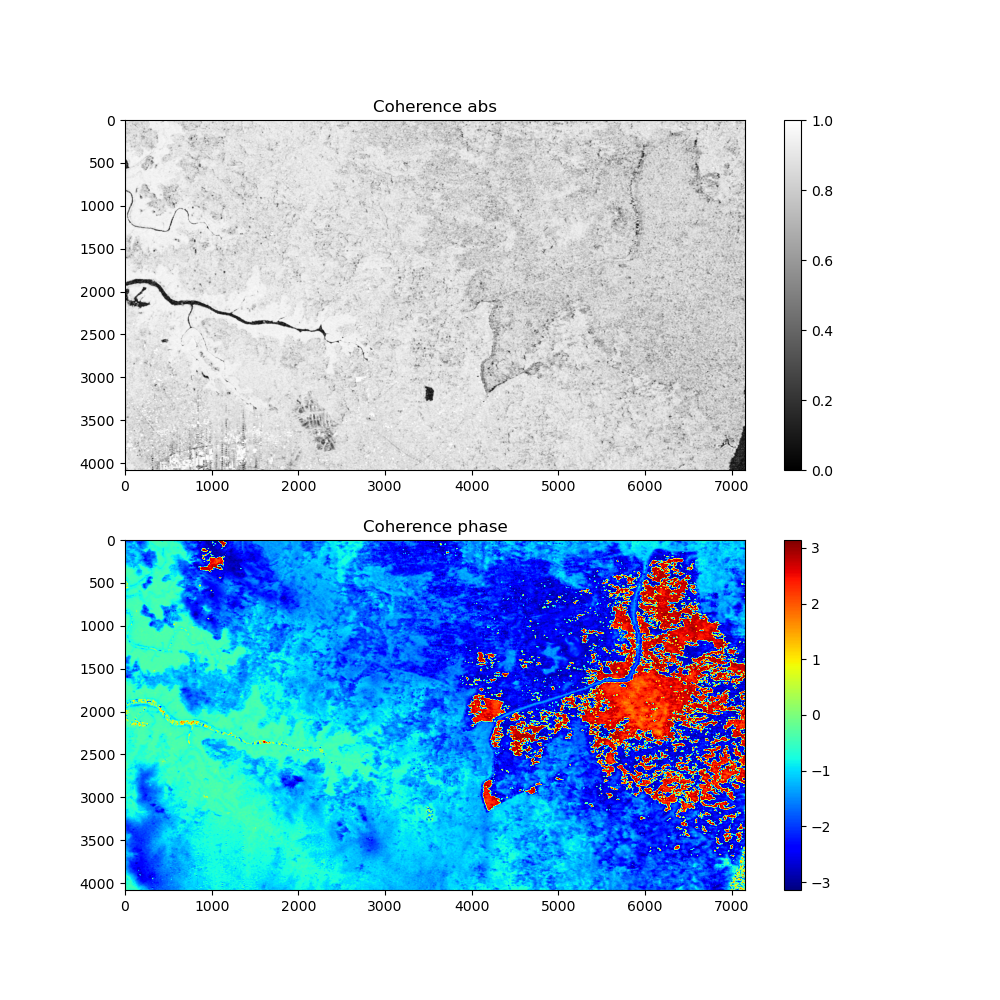

In [8]:
# --- calculate coherence and display
coherence = calculate_covariance(im1, im2_fe, looksr, looksa)
amp1 = np.sqrt( np.abs(calculate_covariance(im1, im1, looksr, looksa)) )
amp2 = np.sqrt( np.abs(calculate_covariance(im2_fe, im2_fe, looksr, looksa)) )
coherence = coherence / amp1 / amp2

# display ...
plt.figure(figsize = (10, 10))
plt.subplot(2, 1, 1)
plt.imshow(np.abs(coherence), vmin = 0, vmax = 1, aspect = 'auto', cmap = 'gray' )
plt.title('Coherence abs')
plt.colorbar()
plt.subplot(2, 1, 2)
plt.imshow(np.angle(coherence), vmin = -np.pi, vmax = np.pi, aspect = 'auto', cmap = 'jet' )
plt.title('Coherence phase')
plt.colorbar()



**Step 4.1 : Invert for forest height, closed-form**

In [9]:
# --- Compensate system decorrelation
gammavol = np.abs(coherence) / 0.97
gammavol[ gammavol > 1 ] = 1



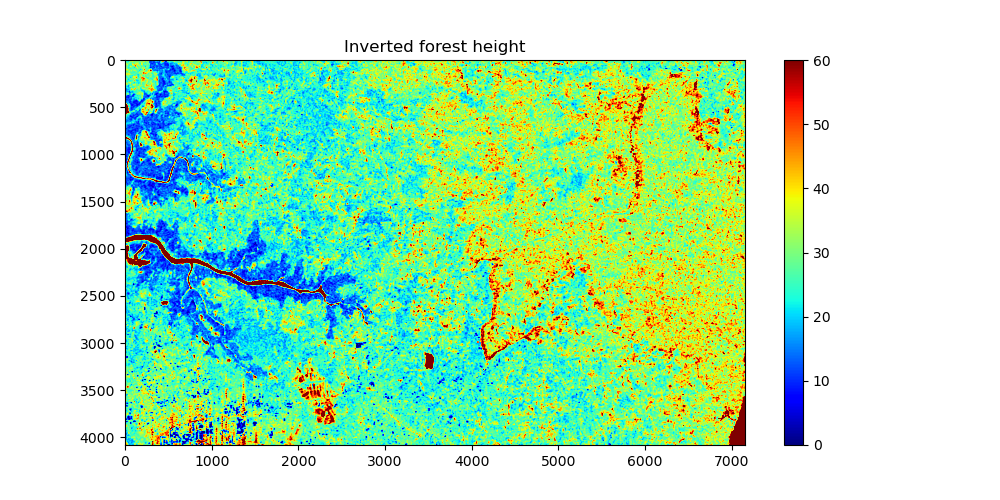

In [10]:
# --- height inversion
hv = 2*np.pi / kz * (1 - 2/np.pi*np.arcsin(gammavol**.8) )

# display
plt.figure(figsize = (10, 5))
plt.imshow(hv, vmin = 0, vmax = 60, aspect = 'auto', cmap = 'jet' )
plt.title('Inverted forest height')
plt.colorbar()

**Step 4.2 : Invert for forest height, use profile**

In [11]:
# --- load lidar profile
profile = np.load(path + 'common_profile.npy')
f_z = profile[30, :]
# number of height samples
nz  = f_z.size
# normalized z axis
znorm = np.linspace(0, 1, nz)

Text(0.5, 1.0, 'Assumed profile')

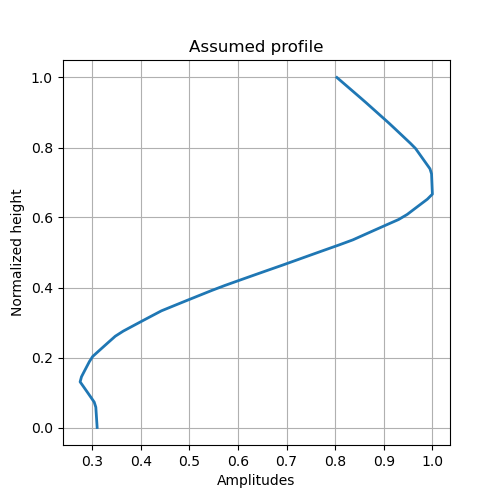

In [12]:
plt.figure(figsize = (5,5))
plt.plot(f_z, znorm, lw = 2)
plt.grid()
plt.xlabel('Amplitudes')
plt.ylabel('Normalized height')
plt.title('Assumed profile')

Text(0.5, 1.0, 'Look-up table for f(z)')

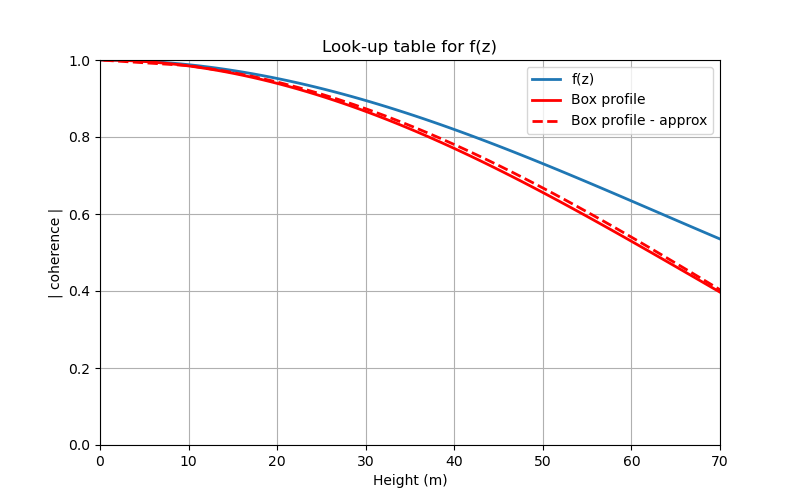

In [13]:
# --- make coherence look-up table for the assumed profile
ztry = np.linspace(0, 70, 70)
coh_lut = np.zeros(ztry.size, 'float32')
for nn in range(ztry.size):
    coh_lut[nn] = np.abs( np.sum(f_z * np.exp(1j*kz*znorm*ztry[nn])) / np.sum(f_z) )
    
# --- make lut for box
coh_lut_box = np.sinc(kz*ztry/2/np.pi)

# make lut (... inverted ...) for approximated box
cohtry = np.linspace(0, 1, 70)
hlut_box_approx =  2*np.pi / kz * (1 - 2/np.pi*np.arcsin(cohtry**.8) )
    
# --- display look-up table
plt.figure(figsize = (8,5))
plt.axis( [np.min(ztry), np.max(ztry), 0, 1] )
plt.plot(ztry, coh_lut, lw = 2, label = 'f(z)')
plt.plot(ztry, coh_lut_box, lw = 2, c='r', label = 'Box profile')
plt.plot(hlut_box_approx, cohtry, '--r', lw = 2, label = 'Box profile - approx')
plt.grid()
plt.legend()
plt.xlabel('Height (m)')
plt.ylabel('| coherence |')
plt.title('Look-up table for f(z)')


In [14]:
# --- Inversion with look-up table
hv_fz = np.zeros(gammavol.size, 'float32')
gammavol_vec = np.reshape(gammavol, [gammavol.size])

for nn in tqdm( range(gammavol_vec.size) ) :
    ix = np.argmin(np.abs(coh_lut - gammavol_vec[nn]))
    hv_fz[nn] = ztry[ix]

del gammavol_vec

# reshape ...
hv_fz = np.reshape(hv_fz, gammavol.shape)


100%|█████████████████████████████████████████████| 29187312/29187312 [01:56<00:00, 250710.61it/s]


**Step 5 : Validation**

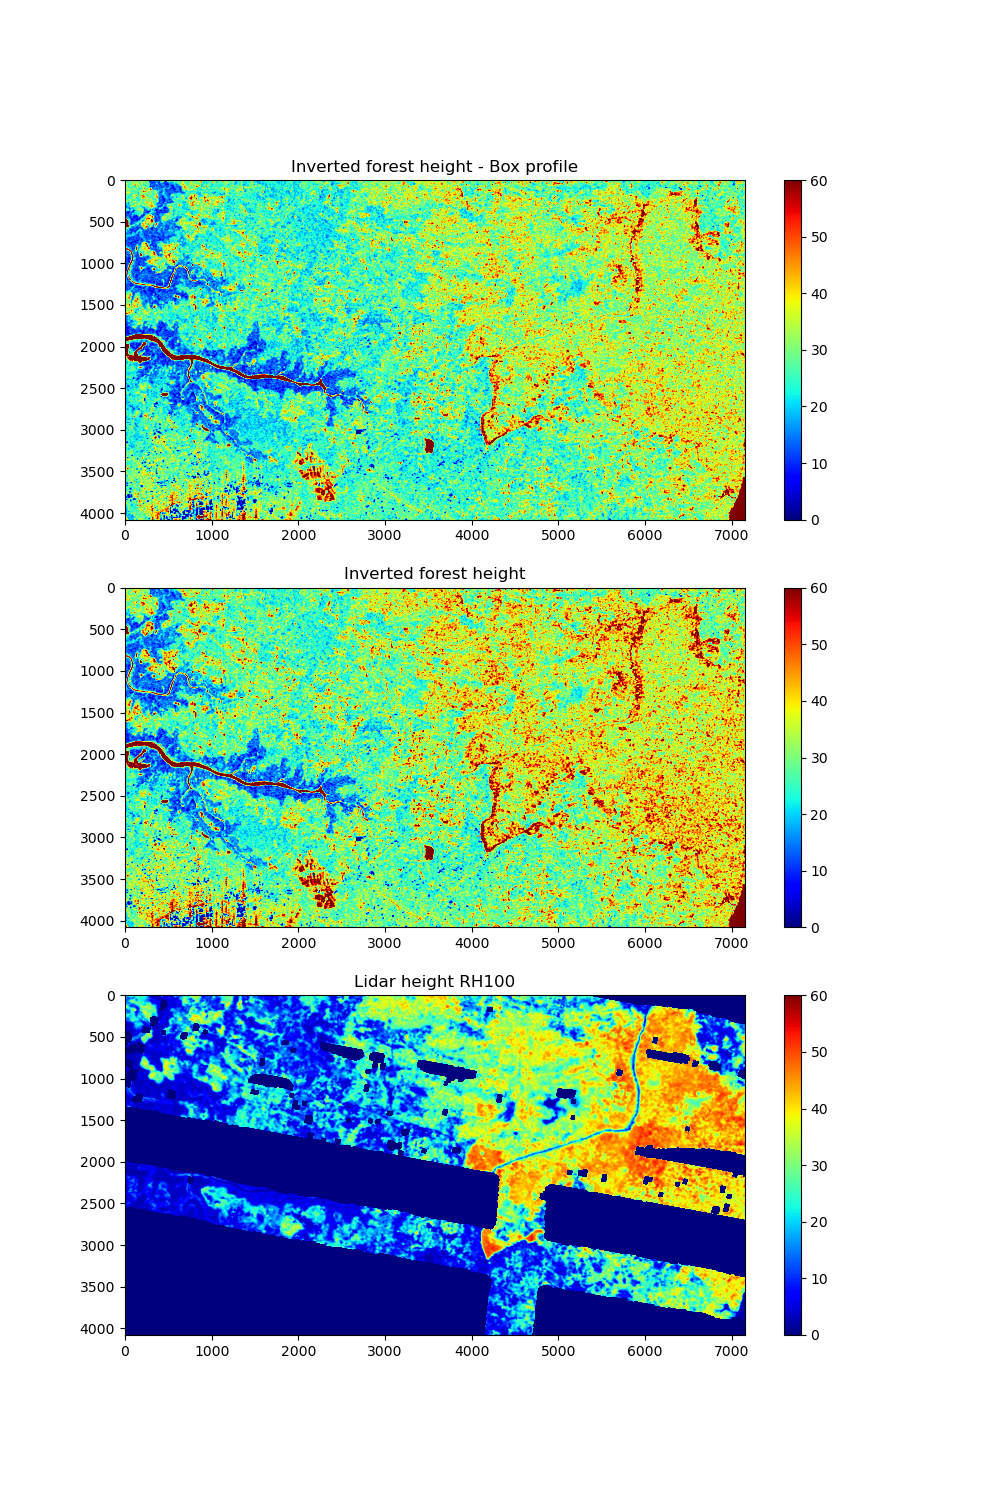

In [15]:
rh100 = np.load(path + 'RH100_Mondah_S_2015_11_11_cut.npy')

plt.figure(figsize = (10, 15))

plt.subplot(3, 1, 1)
plt.imshow(hv, vmin = 0, vmax = 60, aspect = 'auto', cmap = 'jet' )
plt.title('Inverted forest height - Box profile')
plt.colorbar()

plt.subplot(3, 1, 2)
plt.imshow(hv_fz, vmin = 0, vmax = 60, aspect = 'auto', cmap = 'jet' )
plt.title('Inverted forest height')
plt.colorbar()

plt.subplot(3, 1, 3)
plt.imshow(rh100, vmin = 0, vmax = 60, aspect = 'auto', cmap = 'jet' )
plt.title('Lidar height RH100')
plt.colorbar()

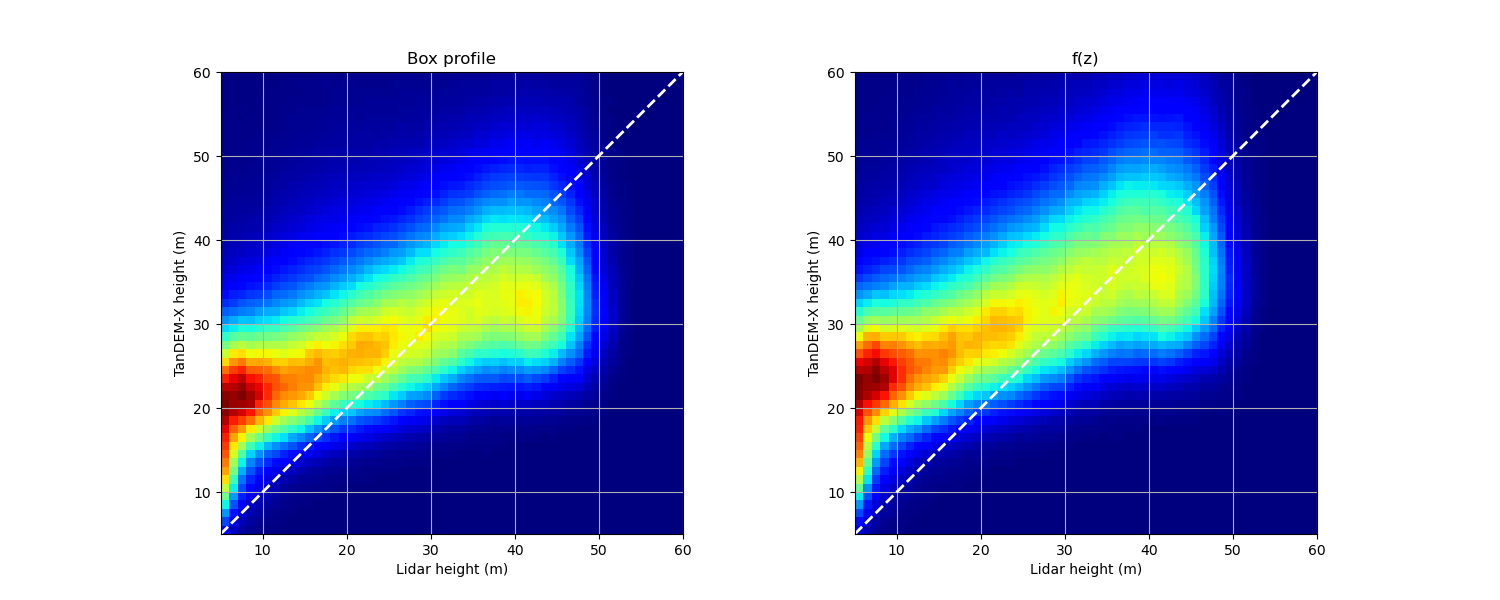

In [16]:
# --- 2-D validation histograms

hist2d_hv = np.histogram2d(rh100[rh100 > -9999], hv[rh100 > -9999], bins = 55, \
                               range = [[5, 60], [5, 60]])

hist2d_hv_fz = np.histogram2d(rh100[rh100 > -9999], hv_fz[rh100 > -9999], bins = 55, \
                               range = [[5, 60], [5, 60]])

# ... display

plt.figure( figsize = (15,6) )

plt.subplot(1, 2, 1)
plt.imshow(np.flipud(np.transpose(hist2d_hv[0])), aspect = 1, extent = [5, 60, 5, 60], cmap ='jet' )
plt.plot((5, 60), (5, 60), lw = 2, color ='w', linestyle = '--')
plt.xlabel('Lidar height (m)')
plt.ylabel('TanDEM-X height (m)')
plt.title('Box profile')
plt.grid()

plt.subplot(1, 2, 2)
plt.imshow(np.flipud(np.transpose(hist2d_hv_fz[0])), aspect = 1, extent = [5, 60, 5, 60], cmap ='jet' )
plt.plot((5, 60), (5, 60), lw = 2, color ='w', linestyle = '--')
plt.xlabel('Lidar height (m)')
plt.ylabel('TanDEM-X height (m)')
plt.title('f(z)')
plt.grid()



